# Pairs Trading with PCA and DBSCAN Clustering
**Group member:
Yicheng Wang, Guoyang Wan, Siyuan Liu**


## Assumptions
1. one pair from each cluster to diversify our portfolio, or pairs with lowest p-value among all the clusters
2. each pair is assigned $ \$ $1,000,000 with a stop loss level to construct the portfolio
3. the portfolio is dollar neutral for each pair and for overall portfolio
4. 20100101-20150101 is the time period we construct our cluster and it is fixed throughout the testing
5. we pick the best pair from each cluster in a rolling basis for a training period, or optimal pairs among all the clsuters
6. we also tried different testing periods until 20180507
7. we also tried different lookback periods and band width for constructing Bollinger band for each pair trade
8. we also tried to apply kalman filter to generate dynamic hedge ratio

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

import matplotlib.cm as cm
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from pykalman import KalmanFilter

from statsmodels.tsa.stattools import coint

from scipy import stats
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
np.zeros(2)

array([0., 0.])

## Data
**Time: ** 2010-01-01 to 2018-05-07  
**Stocks: ** 3000 stocks from Russell3000, Russell3000 index as benchmark  
**Factors: ** Daily closing price, Industry(GICS Industry Group), Analyst Rating, Market to Book Value, Return on Assets, Debt to Assets, Earnings per Share, Market Capitalization

In [2]:
# read Stock price and financial factors
xls = pd.ExcelFile("ProjectData.xlsx")
Price = pd.read_excel(xls,"Russell3000 Price") # stock price
Industry = pd.read_excel(xls,"Industry")
AR = pd.read_excel(xls,"AnalystRating")
MTBV = pd.read_excel(xls,"MarketToBookValue")
ROA = pd.read_excel(xls,"ROA" )
DTA = pd.read_excel(xls,"DebtToAsset")
EPS = pd.read_excel(xls,"EPS")
MC = pd.read_excel(xls,"MarketCap")

In [3]:
# read benchmark data
Russell = pd.read_excel("RU3000PR.xlsx")
Russell = Russell.dropna(axis=0, how='any')
Russell = Russell.set_index("observation_date")

In [4]:
# preprocess stock price and Industry classification
Price = Price.set_index("Dates")
# industry from 1-11
Industry = (Industry['GICS_SECTOR'] - 5 )/ 5
Industry = np.reshape(Industry, (1, np.size(Industry)))
Price_Factor = Price.copy()

In [5]:
# preprocess financial factors
ContVal = [AR, MTBV, ROA, DTA, EPS, MC]
for i in range(len(ContVal)):
    ContVal[i] = pd.DataFrame(ContVal[i])
    ContVal[i] = ContVal[i].set_index("Dates")
    ContVal[i] = ContVal[i].loc["2014-12-31", :]
    ContVal[i] = pd.qcut(ContVal[i], 5, labels=range(1,6,1))
    ContVal[i] = np.reshape(ContVal[i], (1, np.size(ContVal[i])))

In [6]:
ContVal_name = ['AR', 'MTBV', 'ROA', 'DTA', 'EPS', 'MC']
for i in range(len(ContVal)):
    Price_Factor.loc[ContVal_name[i],:] = ContVal[i][0]
Price_Factor.loc["Industry",:] = Industry

# Price_Factor: save stock price and finacial factors of each stock, drop NA
Price_Factor = Price_Factor.dropna(axis=1, how='any')
Price_Factor.shape # 1905 stocks

(2184, 1905)

## PCA
To reduce dimension of daily price returns to 50 dimensions so that we can cluster from (50 + number of factors) dimensions

In [7]:
# daily return dataframe
Price = Price_Factor.iloc[:-7,:]
Price.index = pd.to_datetime(Price.index)
df_ret = Price.pct_change()
df_ret.head()
df_ret.dropna(axis=0, inplace=True) # drop first row (NA)

In [8]:
# 5 year return data for clustering
df_ret_train = df_ret.loc[:'20150101',:]
df_ret_train.T.shape

(1905, 1304)

In [9]:
# PCA
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(df_ret_train)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [10]:
pca.components_.T.shape # reduce to 50 dimensions of 1905 stocks

(1905, 50)

In [11]:
X = np.hstack(
    (pca.components_.T, # return data after PCA
     Price_Factor.iloc[-7:,:].T # factor data
     )
)
X.shape

(1905, 57)

## DBSCAN Clustering
cluster 1905 stocks with 57 dimensions

In [12]:
# standardize data for clustering
X = preprocessing.StandardScaler().fit_transform(X)
print(X.shape) # 57 dimensions by adding 7 factors

(1905, 57)


In [13]:
clf = DBSCAN(eps=1.8, min_samples=3)
print(clf)

# labels is label values from -1 to x
# -1 represents noisy samples that are not in clusters
clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) # eliminate noisy samples
print("\nClusters discovered: %d" % n_clusters_)

clustered = clf.labels_

DBSCAN(algorithm='auto', eps=1.8, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=3, n_jobs=1, p=None)

Clusters discovered: 10


In [14]:
# all stock with its cluster label (including -1)
clustered_series = pd.Series(index=df_ret_train.columns, data=clustered.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=df_ret_train.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [15]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print("Clusters formed: %d" % len(ticker_count_reduced))
print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 10
Pairs to evaluate: 13920


In [16]:
# to plot multidimension into 2D
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

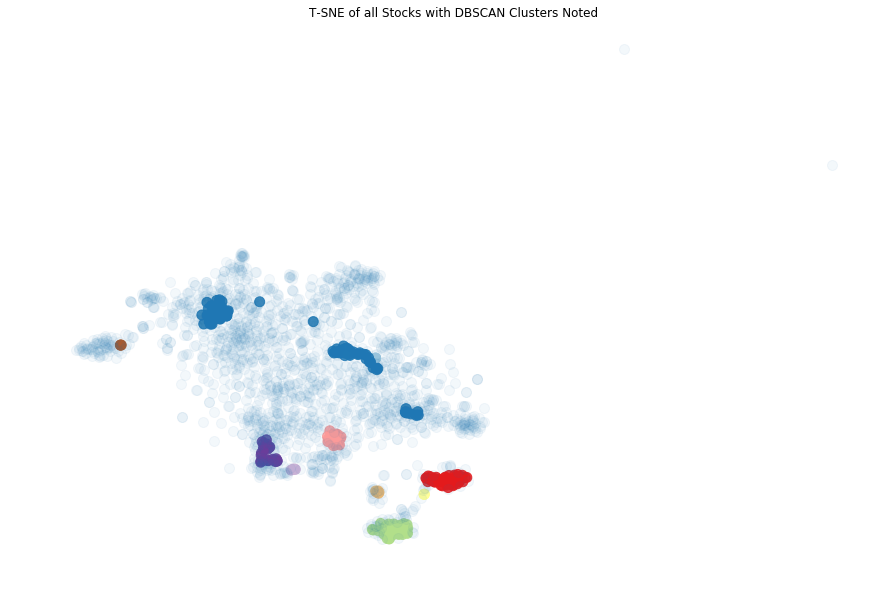

In [17]:
# PLOT
plt.figure(1, facecolor='white', figsize=(15,10))
plt.clf()
plt.axis('off')

# clustered
plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

# unclustered in the background
plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted')
plt.show()

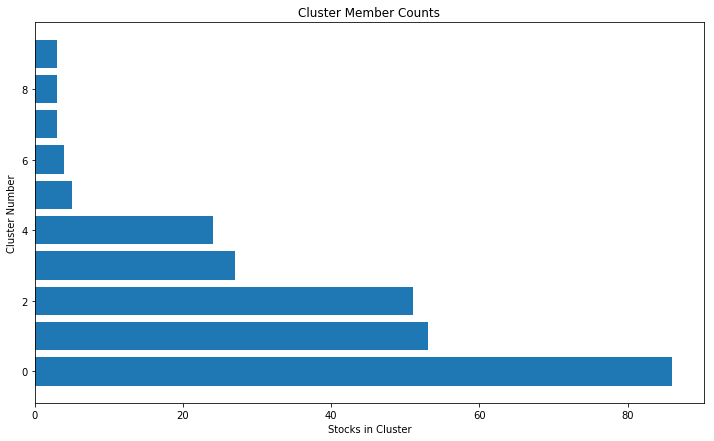

In [18]:
# show number of clusters in each cluster
plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series.value_counts())), # cluster labels, y axis
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

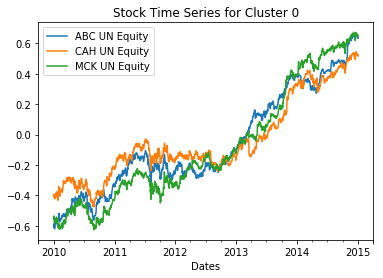

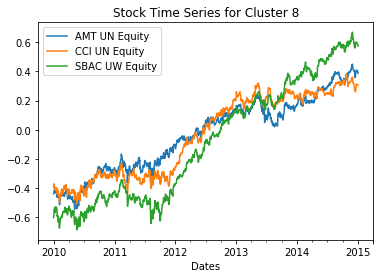

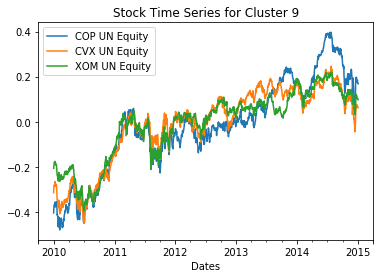

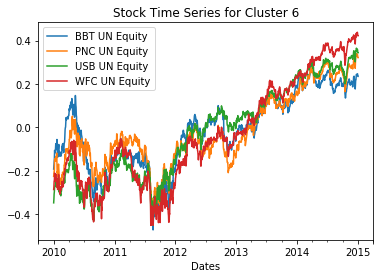

In [19]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 4)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(Price.loc[:"2015-01-01", tickers].mean())
    data = np.log(Price.loc[:"2015-01-01", tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)
plt.show()

## Pair Trading

### $Cointegration$ and $PairSelection$ Function 

In [20]:
'identify cointegrated pairs from clusters'

def Cointegration(cluster, significance, start_day, end_day):
    pair_coin = []
    p_value = []
    n = cluster.shape[0]
    keys = cluster.keys()
    for i in range(n):
        for j in range(i+1,n):
            asset_1 = Price.loc[start_day:end_day, keys[i]]
            asset_2 = Price.loc[start_day:end_day, keys[j]]
            results = sm.OLS(asset_1, asset_2).fit()
            predict = results.predict(asset_2)
            error = asset_1 - predict
            ADFtest = ts.adfuller(error)
            if ADFtest[1] < significance:
                pair_coin.append([keys[i], keys[j]])
                p_value.append(ADFtest[1])
    return p_value, pair_coin

In [38]:
"Pair selection method"
"E_selection = True: select a pair with lowest p-value from each cluster"
"E_selection = False: select pairs among all the cluster cluster"

import heapq
import operator
def PairSelection(clustered_series, significance, start_day, end_day, E_selection):
    Opt_pairs = []   # to get best pair in cluster i
    
    if E_selection == True: # select one pair from each cluster
        for i in range(len(ticker_count_reduced)):
            cluster = clustered_series[clustered_series == i]
            keys = cluster.keys()
            result = Cointegration(cluster, significance, start_day, end_day)
            if len(result[0]) > 0:
                if np.min(result[0]) < significance:
                    index = np.where(result[0] == np.min(result[0]))[0][0]
                    Opt_pairs.append([result[1][index][0], result[1][index][1]]) 
    else:
        p_value_contval = []
        pairs_contval = []
        for i in range(len(ticker_count_reduced)):
            cluster = clustered_series[clustered_series == i]
            keys = cluster.keys()
            result = Cointegration(cluster, significance, start_day, end_day)
            if len(result[0]) > 0:
                p_value_contval += result[0]
                pairs_contval += result[1]
        
        Opt_pair_index = heapq.nsmallest(7, range(len(p_value_contval)), key=p_value_contval.__getitem__)
        Opt_pairs = operator.itemgetter(*Opt_pair_index)(pairs_contval)
    return Opt_pairs

### Preview of selected pairs

In [ ]:
# Pairs with lowest p-value among all the clusters
significance = 0.05
start_day = "2010-01-01"
end_day = "2015-01-01"
E_selection = False

Opt_pairs = PairSelection(clustered_series, significance, start_day, end_day, E_selection)

In [24]:
print("Number of clusters: ",len(ticker_count_reduced))
print("Number of cointegrated pairs: ",len(Opt_pairs))
print("Pairs with lowest p-value among all the clusters:")
Opt_pairs

Number of clusters:  10
Number of cointegrated pairs:  7
Pairs with lowest p-value among all the clusters:


(['AVA UN Equity', 'UTL UN Equity'],
 ['O UN Equity', 'VTR UN Equity'],
 ['EPR UN Equity', 'HIW UN Equity'],
 ['FISV UW Equity', 'SNA UN Equity'],
 ['DDR UN Equity', 'PLD UN Equity'],
 ['DDR UN Equity', 'WRI UN Equity'],
 ['ITW UN Equity', 'ZBH UN Equity'])

In [26]:
# Pairs with lowest p-value of each cluster
significance = 0.05
start_day = "2010-01-01"
end_day = "2015-01-01"
E_selection = True # True: select a pair from each cluster

Opt_pairs = PairSelection(clustered_series, significance, start_day, end_day, E_selection)

print("Number of clusters: ",len(ticker_count_reduced))
print("Number of cointegrated pairs: ",len(Opt_pairs))
print("Pairs with lowest p-value of each cluster:")
Opt_pairs

Number of clusters:  10
Number of cointegrated pairs:  6
Pairs with lowest p-value of each cluster:


[['FISV UW Equity', 'SNA UN Equity'],
 ['O UN Equity', 'VTR UN Equity'],
 ['BRO UN Equity', 'VR UN Equity'],
 ['AVA UN Equity', 'UTL UN Equity'],
 ['TRST UW Equity', 'UBSI UW Equity'],
 ['CVX UN Equity', 'XOM UN Equity']]

## Kalman Filter
### Preview of Cointegrated Patterns

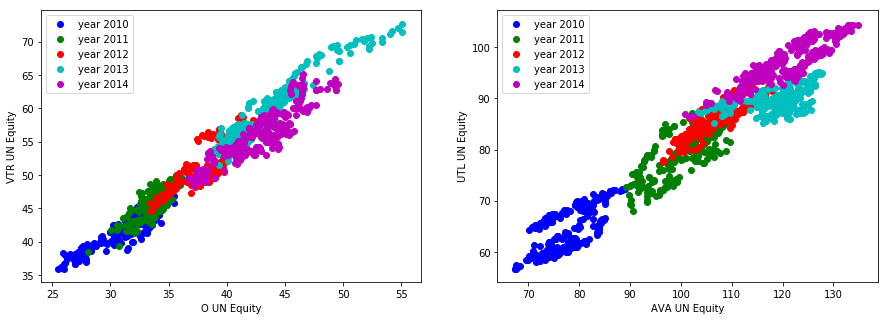

In [29]:
'plot one cointegrated pair in different time interval'
stock_O = Price.loc["2010-01-01":"2015-01-01", Opt_pairs[1][0]]
stock_VTR = Price.loc["2010-01-01":"2015-01-01", Opt_pairs[1][1]]

stock_CVX = Price.loc["2010-01-01":"2015-01-01", Opt_pairs[5][0]]
stock_XOM = Price.loc["2010-01-01":"2015-01-01", Opt_pairs[5][1]]

fig, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize=(15,5))

ax1.set_xlabel("O UN Equity")
ax1.set_ylabel("VTR UN Equity")
ax1.scatter(stock_O[0:252],stock_VTR[0:252], color='b',
            label = 'year 2010')
ax1.scatter(stock_O[252:504],stock_VTR[252:504], color='g',
            label = 'year 2011')
ax1.scatter(stock_O[504:756],stock_VTR[504:756], color='r',
            label = 'year 2012')
ax1.scatter(stock_O[756:1008],stock_VTR[756:1008], color='c',
            label = 'year 2013')
ax1.scatter(stock_O[1008:],stock_VTR[1008:], color='m',
            label = 'year 2014')
ax1.legend()

ax2.set_xlabel("CVX UN Equity")
ax2.set_ylabel("XOM UN Equity")
ax2.scatter(stock_CVX[0:252],stock_XOM[0:252], color='b',
            label = 'year 2010')
ax2.scatter(stock_CVX[252:504],stock_XOM[252:504], color='g',
            label = 'year 2011')
ax2.scatter(stock_CVX[504:756],stock_XOM[504:756], color='r',
            label = 'year 2012')
ax2.scatter(stock_CVX[756:1008],stock_XOM[756:1008], color='c',
            label = 'year 2013')
ax2.scatter(stock_CVX[1008:],stock_XOM[1008:], color='m',
            label = 'year 2014')
ax2.legend()

plt.show()

### Kalman Filter Regression

In [204]:
'kalman filter regression'
# observation matrix

obs_mat = np.vstack([stock_FFBC,
                     np.ones(stock_FFBC.shape)]).T[:, np.newaxis]

delta = 1e-5 # accuracy
trans_cov = delta / (1 - delta) * np.eye(2)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # 2d, a pair, x/y
                  initial_state_mean=np.zeros(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=1.0,
                  transition_covariance=trans_cov)

state_means, state_covs = kf.filter(stock_BRKL)

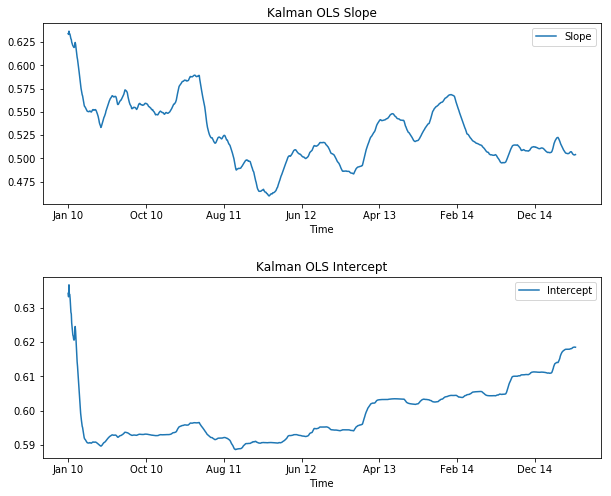

In [208]:
'plot kalman OLS coefficients'

fig, (ax1, ax2) = plt.subplots(2,1, sharex=False,figsize=(10,8))
'plot kalman OLS coefficients: slope'
ax1.set_title('Kalman OLS Slope')
ax1.set_xlabel('Time')
ax1.plot(state_means[:,0], label = 'Slope')
ax1.legend()
# change x label
ax1.set_xticks([0,200,400,600,800,1000,1200]) 
ax1.set_xticklabels(['Jan 10','Oct 10','Aug 11','Jun 12','Apr 13','Feb 14','Dec 14']) 

'plot kalman OLS coefficients: intercept'
ax2.set_title('Kalman OLS Intercept')
ax2.set_xlabel('Time')
ax2.plot(state_means[:,1], label = 'Intercept')
ax2.legend()
# change x label
ax2.set_xticks([0,200,400,600,800,1000,1200]) 
ax2.set_xticklabels(['Jan 10','Oct 10','Aug 11','Jun 12','Apr 13','Feb 14','Dec 14']) 

plt.subplots_adjust(wspace = 1, hspace=0.4)
plt.show()

## Bollinger Band Trading Strategy

### $MovingAverage$, $BBand$, $BBTrading$ and $PortfolioTrading$ Function

In [30]:
'define moving average and rolling std of data series with time period t'
def MVaverage(a, t):
    # a is an array of a vector of data
    # t is the looking back period
    i = np.size(a)
    j = 0
    mv_t = np.zeros(i-t+1)  # moving average of data interval with period t
    std_t = np.zeros(i-t+1) # std of data interval with period t
    while i>(t-1):
        mv_t[j] = np.mean(a[j:(j+t)])
        std_t[j] = np.std(a[j:(j+t)])
        j += 1
        i -= 1
    return mv_t, std_t

In [31]:
'define bollinger band function to calculate Bollinger band width'
def BBand(a, t, const):
    # a is an array of a vector of data
    # t is the looking back period
    # const is the number of std away from the moving average
    BollingerBand = []
    mv, std = MVaverage(a, t)
    LowerBand = np.subtract(mv, const*std)
    UpperBand = np.add(mv, const*std)
    BollingerBand.append([LowerBand, UpperBand])
    return mv, BollingerBand

In [32]:
'define function to calculate maximum drawdown'
def MaxDrawdown(Ret_Cum):
    # ret_cum also can be portfolio position series
    ContVal = np.zeros(np.size(Ret_Cum))
    MaxDD = np.zeros(np.size(Ret_Cum))
    for i in range(np.size(Ret_Cum)):
        if i == 0:
            if Ret_Cum[i] < 0:
                ContVal[i] = Ret_Cum[i]
            else:
                ContVal[i] = 0
        else:
            ContVal[i] = Ret_Cum[i] - np.max(Ret_Cum[0:(i+1)])
        MaxDD[i] = np.min(ContVal[0:(i+1)])
    return MaxDD

In [33]:
'design the black box of moving average trading strategy'
'with bollinger band'
def BBTrading(capital, stock_1, stock_2, t, const, stop_loss, KF):
    # a is an array of a vector of data
    # t is the looking back period
    # const is the number of std away from the moving average
    # stop_loss: amount of loss we take (eg. 0.2*capital)
    # KalmanFilter: True or False, whether use Kalman Filter, default is False
    
    if KF==True:
        obs_mat = np.vstack([stock_2,
                             np.ones(stock_2.shape)]).T[:, np.newaxis]
        delta = 1e-5
        trans_cov = delta / (1 - delta) * np.eye(2)
        kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                          initial_state_mean=np.zeros(2),
                          initial_state_covariance=np.ones((2, 2)),
                          transition_matrices=np.eye(2),
                          observation_matrices=obs_mat,
                          observation_covariance=1.0,
                          transition_covariance=trans_cov)
        state_means, state_covs = kf.filter(stock_1)
        'generate spread based on kalman OLS'
        spread_k = np.zeros(np.size(stock_1))
        for i in range(np.size(spread_k)):
            spread_k[i] = stock_1[i] - state_means[i,0]*stock_2[i] - state_means[i,1]
        a = pd.Series(spread_k)
    
    else:
        results = sm.OLS(stock_1, stock_2).fit()
        predict = results.predict(stock_2)
        a = np.subtract(stock_1, predict)


    mv, BB = BBand(a, t, const) # moving average and bollinger band
    
    
    m = np.size(mv)
    Entry = np.zeros(m-1)  # entry signal
    Holding = np.zeros(m)  # holding state
    PL_Holding = np.zeros(m-1) # holding return
    PL_Cum = np.zeros(m-1) # cumulative return of trading strategy
    
    'produce entry signal'
    for i in range(m-1):
        if i == 0:
            if a[i+t]<BB[0][0][i+1] and a[i+t-1]>BB[0][0][i]:
                Entry[i] = 1
            else:
                Entry[i] = 0
        else:
            if a[i+t]<BB[0][0][i+1] and a[i+t-1]>BB[0][0][i]:
                Entry[i] = 1
            else:
                if a[i+t]>BB[0][1][i+1] and a[i+t-1]<BB[0][1][i]:
                    Entry[i] = -1
                else:
                    Entry[i] = 0
    
    'holding decision'
    for i in range(1,m,1):
        if Entry[i-1]==0:
            Holding[i] = Holding[i-1]
        else:
            if Entry[i-1] + Holding[i-1] == 0:
                Holding[i]=0
            else:
                if np.abs(Entry[i-1]+Holding[i-1])==1:
                    Holding[i] = Entry[i-1] + Holding[i-1]
                else:
                    Holding[i] = Holding[i-1]
           
    PL_Holding = np.multiply(Holding[1:], a[(t):])*(-1) * (capital/stock_1[t])
    PL_Holding.index = range(np.size(PL_Holding))
    
    commission = Entry * (4.95 + 0.0001 * capital)*2
    PL_Holding = PL_Holding - commission 
    
    'Calculate cumulative P/L'
    for i in range(np.size(PL_Holding)):
        if i ==0:
            PL_Cum[i] = PL_Holding[0]
        else:
            PL_Cum[i] = PL_Cum[i-1]  + PL_Holding[i]
    
 
    if np.min(PL_Cum) < (-stop_loss * capital):
        po = np.min(np.where(PL_Cum < (-stop_loss*capital)))
        PL_Cum[po:] = PL_Cum[po]

    po = np.where(PL_Cum < (stop_loss*capital))
    
    'calculate maximum drawdown'
    MaxDD = MaxDrawdown(PL_Cum)    
    
    results = []
    results.append([a, Entry, Holding, PL_Holding, PL_Cum, MaxDD])
    
    return results

In [34]:
def Portfolio(capital, clustered_series, significance, coint_start_day, 
              coint_end_day, t, const, stop_loss, rolling_days, KF, E_selection):
    
    end_day_index = Price.index.get_loc(coint_end_day)
    num = np.size(Price.index)
    
    PL_daily_portfolio = []
    PL_cum_portfolio = []
    
    while(end_day_index < num):
        Opt_pairs = PairSelection(clustered_series, significance, 
                                  coint_start_day, coint_end_day, E_selection)
        num_pairs = len(Opt_pairs) # count pairs
        
        # start date of testing period
        start_day = Price.index[end_day_index -t]
        if (end_day_index + rolling_days) < num:
            end_day = Price.index[end_day_index + rolling_days] # rolling day is 126
        else:
            end_day = Price.index[num-1]
            
        PL_daily_ContVal = [] # save each pair's daily P/L
        
        for i in range(num_pairs):
            stock_1 = Price.loc[start_day:end_day, Opt_pairs[i][0]]
            stock_2 = Price.loc[start_day:end_day:, Opt_pairs[i][1]]
            each_pair = BBTrading(capital, stock_1, stock_2, t, const, stop_loss, KF)
            PL_daily_ContVal.append(each_pair[0][3])
            
            
        PL_daily_portfolio.append(np.sum(PL_daily_ContVal, axis=0))
                   
        coint_start_day = Price.index[Price.index.get_loc(coint_start_day) + rolling_days]
        coint_end_day_index = Price.index.get_loc(coint_end_day) +rolling_days
        if coint_end_day_index < num:
            coint_end_day = Price.index[coint_end_day_index]
            end_day_index = coint_end_day_index
        else:
            end_day_index = coint_end_day_index
    
    
    PL_daily_portfolio = list(itertools.chain.from_iterable(PL_daily_portfolio))
    PL_cum_portfolio = np.zeros(np.size(PL_daily_portfolio))
    for i in range(np.size(PL_daily_portfolio)):
        if i==0:
            PL_cum_portfolio[i] = PL_daily_portfolio[i]
        else:
            PL_cum_portfolio[i] = PL_cum_portfolio[i-1] + PL_daily_portfolio[i]

    maxdd_portfolio = MaxDrawdown(PL_cum_portfolio)

    return PL_daily_portfolio, PL_cum_portfolio, maxdd_portfolio, num_pairs

### Visualize performance for one pair with or without Kalman Filter

In [141]:
# one pair, trading performance
stock_1 = Price.loc["2015-01-01":, Opt_pairs[1][0]]
stock_2 = Price.loc["2015-01-01":, Opt_pairs[1][1]]
t = 100
const = 1.5
stop_loss = 0.2
capital = 1000000

test_pair_T = BBTrading(capital, stock_1, stock_2, t, const, stop_loss, KF=True)
test_pair_F = BBTrading(capital, stock_1, stock_2, t, const, stop_loss, KF=False)
# return: spread, Entry, Holding, PL_Holding, PL_Cum, MaxDD

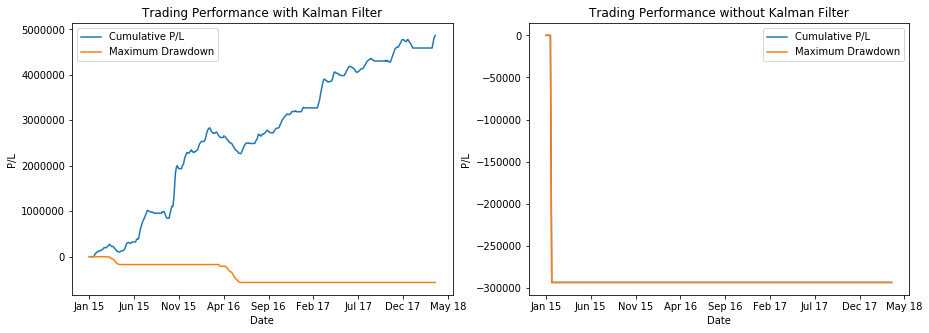

In [146]:
# a pair trading performance with/without Kalman Filter
fig, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize=(15,5))

ax1.set_title("Trading Performance with Kalman Filter")
ax1.set_xlabel("Date")
ax1.set_ylabel("P/L")
ax1.plot(test_pair_T[0][4], label="Cumulative P/L")
ax1.plot(test_pair_T[0][5], label="Maximum Drawdown")
ax1.legend()
ax1.set_xticks(range(0,900,100))
ax1.set_xticklabels(['Jan 15','Jun 15','Nov 15',
                     'Apr 16','Sep 16','Feb 17','Jul 17','Dec 17','May 18'])


ax2.set_title("Trading Performance without Kalman Filter")
ax2.set_xlabel("Date")
ax2.set_ylabel("P/L")
ax2.plot(test_pair_F[0][4], label="Cumulative P/L")
ax2.plot(test_pair_F[0][5], label="Maximum Drawdown")
ax2.legend()
ax2.set_xticks(range(0,900,100))
ax2.set_xticklabels(['Jan 15','Jun 15','Nov 15',
                     'Apr 16','Sep 16','Feb 17','Jul 17','Dec 17','May 18'])
plt.show()

## Portfolio Compared with Benchmark

In [148]:
capital = 1000000 # capital for each pair
total_capital = len(Opt_pairs)*capital
print('Capital for each pair: '+str(capital))
print('Total capital invested in portfolio: ' + str(total_capital))

Capital for each pair: 1000000
Total capital invested in portfolio: 7000000


In [35]:
# benchmark cumulative return
Russell = Russell.loc["2014-12-31":, :]
ret_daily_russell = np.log(np.divide(Russell.iloc[1:,0], Russell.iloc[:-1,0]))
ret_cum_russell = np.zeros(np.size(ret_daily_russell))
for i in range(np.size(ret_daily_russell)):
    if i == 0:
        ret_cum_russell[i] = ret_daily_russell[i]
    else:
        ret_cum_russell[i] = ret_cum_russell[i-1] + ret_daily_russell[i]

In [151]:
"Portfolio trading performance"
significance = 0.05
capital = 1000000
coint_start_day = "2010-01-01" # cointegration test start day
coint_end_day = "2015-01-01"   # cointegration test end day

t = 100 # lookback days
const = 1.5 # band width
stop_loss = 0.2
rolling_days = 126 # testing period
KF = True # whether use kalman Filter, True or False

# one pair from each cluster
test_port_T = Portfolio(capital, clustered_series, significance, coint_start_day,
                         coint_end_day, t, const, stop_loss, rolling_days, KF, E_selection=True)
# best pairs from all clusters
test_port_F = Portfolio(capital, clustered_series, significance, coint_start_day,
                         coint_end_day, t, const, stop_loss, rolling_days, KF, E_selection=False)

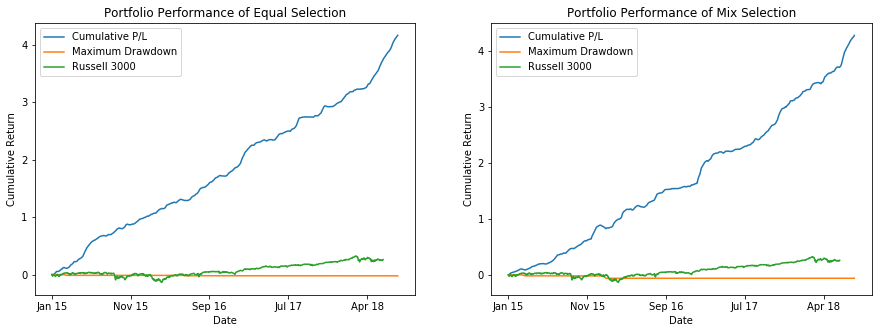

In [187]:
# a pair trading performance with Kalman Filter, and equal/mix selection
fig, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize=(15,5))

ax1.set_title("Portfolio Performance of Equal Selection")
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative Return")
ax1.plot(test_port_T[1]/(capital*7), label="Cumulative P/L")
ax1.plot(test_port_T[2]/(capital*7), label="Maximum Drawdown")
ax1.plot(ret_cum_russell, label = "Russell 3000")
ax1.legend()
ax1.set_xticks([0,200,400,600,800]) 
ax1.set_xticklabels(['Jan 15','Nov 15','Sep 16','Jul 17','Apr 18']) 

ax2.set_title("Portfolio Performance of Mix Selection")
ax2.set_xlabel("Date")
ax2.set_ylabel("Cumulative Return")
ax2.plot(test_port_F[1]/(capital*7), label="Cumulative P/L")
ax2.plot(test_port_F[2]/(capital*7), label="Maximum Drawdown")
ax2.plot(ret_cum_russell, label = "Russell 3000")
ax2.legend()
ax2.set_xticks([0,200,400,600,800]) 
ax2.set_xticklabels(['Jan 15','Nov 15','Sep 16','Jul 17','Apr 18']) 

plt.show()

In [186]:
# total return and sharp ratio
print("Trading period: Jan 1, 2015 - May 7, 2018")
print("Russell 3000, total return: ",ret_cum_russell[-1])
print("Russell 3000, shape ratio: ",np.nanmean(ret_daily_russell)/np.nanstd(ret_daily_russell))
print("Equal selection, total return: ", test_port_T[1][-1]/total_capital)
print("Equal selection, sharp ratio:", np.nanmean(test_port_T[0])/np.nanstd(test_port_T[0]))
print("Mix selection, total return: ", test_port_F[1][-1]/total_capital)
print("Mix selection, sharp ratio:", np.nanmean(test_port_F[0])/np.nanstd(test_port_F[0]))

Trading period: Jan 1, 2015 - May 7, 2018
Russell 3000, total return:  0.2599044812785878
Russell 3000, shape ratio:  0.03706069642439636
Equal selection, total return:  4.160061172655936
Equal selection, sharp ratio: 0.973699138500516
Mix selection, total return:  4.277556105551584
Mix selection, sharp ratio: 0.7929686919732171


One pair from each cluster performs better because of low correlation between pairs.

## Portfolio Optimization
by changing parameters

In [154]:
port_compare = pd.DataFrame(columns=['port','train_months','test_days','lookback_days','band_width',
                                     'stop_loss','Kalman_Filter','Sharpe'])

### Optimize for Bollinger Band Strategy for Each Pair Trade
fix training period 5-year, stop loss level, testing period 0.5-year

In [157]:
port_compare_1 = pd.DataFrame(columns=['port','train_months','test_days','lookback_days','band_width',
                                     'stop_loss','Kalman_Filter','Sharpe'])

In [158]:
significance = 0.05
capital = 1000000
coint_start_day = "2010-01-01" # cointegration test start day
coint_end_day = "2015-01-01"   # cointegration test end day
train_month = 60
lookback_days = [20, 50, 100, 200]
band_width = [1.5, 2, 2.5]
stop_loss = 0.2
rolling_days = 126
KF = True 
E_selection = False

n = 0
for t in lookback_days:
    for const in band_width:
        n += 1
        port = Portfolio(capital, clustered_series, significance, coint_start_day,
                         coint_end_day, t, const, stop_loss, rolling_days, KF, E_selection)
        sharpe = np.nanmean(port[0])/np.nanstd(port[0])
        port_compare_1.loc[n, :] = [port, train_month, rolling_days, t, const, stop_loss, KF, sharpe]

In [159]:
save1 = port_compare_1.copy()
save1

,port,train_months,test_days,lookback_days,band_width,stop_loss,Kalman_Filter,Sharpe
1,"([0.0, 0.0, 51376.205580549926, 43016.74917161...",60,126,20,1.5,0.2,True,1.10832
2,"([0.0, 0.0, 51376.205580549926, 32619.98521171...",60,126,20,2,0.2,True,0.920283
3,"([0.0, 0.0, 51376.205580549926, 32619.98521171...",60,126,20,2.5,0.2,True,0.629173
4,"([0.0, 0.0, 41675.17989623978, 42150.573654585...",60,126,50,1.5,0.2,True,0.980591
5,"([0.0, 0.0, 41675.17989623978, 32422.896102090...",60,126,50,2,0.2,True,0.636623
6,"([0.0, 0.0, 41675.17989623978, 32422.896102090...",60,126,50,2.5,0.2,True,0.575766
7,"([0.0, 0.0, 41663.77518432925, 42054.266838365...",60,126,100,1.5,0.2,True,0.792969
8,"([0.0, 0.0, 41663.77518432925, 32418.306420600...",60,126,100,2,0.2,True,0.661294
9,"([0.0, 0.0, 41663.77518432925, 32418.306420600...",60,126,100,2.5,0.2,True,0.558647
10,"([0.0, 0.0, 41668.79580473811, 32420.322995752...",60,126,200,1.5,0.2,True,0.813391


In [161]:
# without Kalman Filter
port_compare_2 = pd.DataFrame(columns=['port','train_months','test_days','lookback_days','band_width',
                                     'stop_loss','Kalman_Filter','Sharpe'])

In [162]:
significance = 0.05
capital = 1000000
coint_start_day = "2010-01-01" # cointegration test start day
coint_end_day = "2015-01-01"   # cointegration test end day
train_month = 60
lookback_days = [20, 50, 100, 200]
band_width = [1.5, 2, 2.5]
stop_loss = 0.2
rolling_days = 126
KF = False
E_selection = True

n = 0
for t in lookback_days:
    for const in band_width:
        n += 1
        port = Portfolio(capital, clustered_series, significance, coint_start_day,
                         coint_end_day, t, const, stop_loss, rolling_days, KF, E_selection)
        sharpe = np.nanmean(port[0])/np.nanstd(port[0])
        port_compare_2.loc[n, :] = [port, train_month, rolling_days, t, const, stop_loss, KF, sharpe]


In [163]:
port_compare_2

,port,train_months,test_days,lookback_days,band_width,stop_loss,Kalman_Filter,Sharpe
1,"([0.0, 0.0, 0.0, -44268.916779650615, -10279.7...",60,126,20,1.5,0.2,False,0.948962
2,"([0.0, 0.0, 0.0, 0.0, -3500.9965207924306, -19...",60,126,20,2,0.2,False,0.971121
3,"([0.0, 0.0, 0.0, 0.0, 0.0, -13057.247699164353...",60,126,20,2.5,0.2,False,0.836479
4,"([0.0, 0.0, 0.0, -32200.2805991863, -29752.611...",60,126,50,1.5,0.2,False,1.08567
5,"([0.0, 0.0, 0.0, 0.0, -28802.075036284084, -41...",60,126,50,2,0.2,False,0.923465
6,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5726.599938589...",60,126,50,2.5,0.2,False,0.825383
7,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42462.39046307...",60,126,100,1.5,0.2,False,0.988879
8,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",60,126,100,2,0.2,False,1.021
9,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",60,126,100,2.5,0.2,False,0.696258
10,"([0.0, 0.0, 0.0, 0.0, 35650.48687635291, 30454...",60,126,200,1.5,0.2,False,1.31589


### Optimize for testing and training periods

In [ ]:
port_compare_3 = pd.DataFrame(columns=['port','train_months','test_days','lookback_days','band_width',
                                     'stop_loss','Kalman_Filter','Sharpe'])

In [ ]:
significance = 0.05
capital = 1000000
train_month = range(48,1,-12)
lookback_days = [20, 50, 100]
band_width = [1.5, 2] # [1, 1.5, 2]
stop_loss = 0.2 # only useful when KF is False
test_days = [21, 63, 126, 252]
Kalman = [True, False] # whether use kalman Filter, True or False

n = 0
for tm in range(len(train_month)):
    train_period = train_date[tm]
    coint_start_day = train_period[0]
    coint_end_day = train_period[1]
    
    for t in lookback_days:
        for const in band_width:
#             for stop_loss in stoploss:
            for rolling_days in test_days:
                n += 1
                port = Portfolio(capital, clustered_series, significance, coint_start_day,
                                  coint_end_day, t, const, stop_loss, rolling_days, KF)
                sharpe = np.nanmean(port[0])/np.nanstd(port[0])
                port_compare_3.loc[n, :] = [port, train_month[tm], rolling_days, t, const, stop_loss, KF, sharpe]

In [151]:
port_compare_3

,port,train_months,test_days,lookback_days,band_width,stop_loss,Kalman_Filter,Sharpe
1,"([0.0, 0.0, 46528.14028730437, 43146.518784630...",60,21,20,1,0.1,True,1.24564
2,"([0.0, 0.0, 46528.14028730437, 43146.518784630...",60,63,20,1,0.1,True,1.40082
3,"([0.0, 0.0, 46528.14028730437, 43146.518784630...",60,126,20,1,0.1,True,1.46476
4,"([0.0, 0.0, 46528.14028730437, 43146.518784630...",60,252,20,1,0.1,True,1.33455
5,"([0.0, 0.0, 46528.14028730437, 43146.518784630...",60,21,20,1,0.2,True,1.24564
6,"([0.0, 0.0, 46528.14028730437, 43146.518784630...",60,63,20,1,0.2,True,1.40082
7,"([0.0, 0.0, 46528.14028730437, 43146.518784630...",60,126,20,1,0.2,True,1.46476
8,"([0.0, 0.0, 46528.14028730437, 43146.518784630...",60,252,20,1,0.2,True,1.33455
9,"([0.0, 0.0, 46528.14028730437, 43146.518784630...",60,21,20,1,0.5,True,1.24564
10,"([0.0, 0.0, 46528.14028730437, 43146.518784630...",60,63,20,1,0.5,True,1.40082


### Optimized Portfolio compared with Benchmark

In [39]:
"Portfolio trading performance"
significance = 0.05
capital = 1000000
coint_start_day = "2014-01-02" # cointegration test start day
coint_end_day = "2015-01-01"   # cointegration test end day

t = 100 # lookback days
const = 1 # band width
stop_loss = 0.2
rolling_days = 126 # testing period

Optimized_port = Portfolio(capital, clustered_series, significance, coint_start_day,
                         coint_end_day, t, const, stop_loss, rolling_days, KF=True, E_selection=True)


In [41]:
total_capital = capital * Optimized_port[-1]

[Text(0,0,'Jan 15'),
 Text(0,0,'Nov 15'),
 Text(0,0,'Sep 16'),
 Text(0,0,'Jul 17'),
 Text(0,0,'Apr 18')]

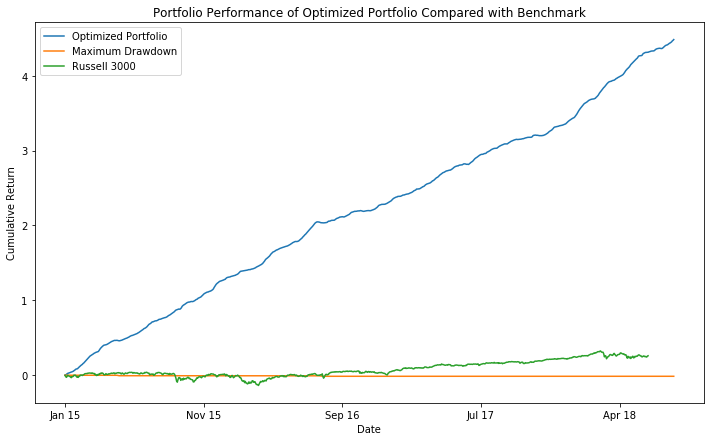

In [49]:
fig, ax1 = plt.subplots(figsize=(12,7))
ax1.set_title("Portfolio Performance of Optimized Portfolio Compared with Benchmark")
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative Return")
ax1.plot(Optimized_port[1]/total_capital, label="Optimized Portfolio")
ax1.plot(Optimized_port[2]/total_capital, label="Maximum Drawdown")
ax1.plot(ret_cum_russell, label = "Russell 3000")
ax1.legend()
ax1.set_xticks([0,200,400,600,800]) 
ax1.set_xticklabels(['Jan 15','Nov 15','Sep 16','Jul 17','Apr 18']) 

In [52]:
# total return and sharp ratio
print("Trading period: Jan 1 2015 - May 7, 2018")
print("Russell 3000, total return: ",ret_cum_russell[-1])
print("Russell 3000, shape ratio: ",np.nanmean(ret_daily_russell)/np.nanstd(ret_daily_russell))
print("Optimized Portfolio, total return: ", Optimized_port[1][-1]/total_capital)
print("Optimized Portfolio, sharp ratio:", np.nanmean(Optimized_port[0])/np.nanstd(Optimized_port[0]))
print("Optimized Portfolio Total profit: ", Optimized_port[1][-1])

Trading period: Jan 1 2015 - May 7, 2018
Russell 3000, total return:  0.2599044812785878
Russell 3000, shape ratio:  0.03706069642439636
Optimized Portfolio, total return:  4.481015884979954
Optimized Portfolio, sharp ratio: 1.3341860596845443
Optimized Portfolio Total profit:  31367111.19485968
